In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


4431872/4422102 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y =(60000,)
Test: X=(10000, 28, 28), y =(10000,)


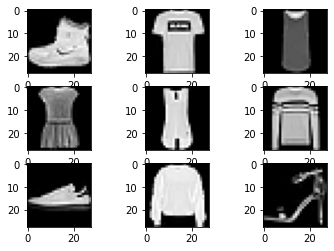

In [ ]:
#preview dataset

from matplotlib import pyplot
from keras.datasets import fashion_mnist
from PIL import Image
import numpy
#load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# summarize loaded dataset

print('Train: X=%s, y =%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y =%s' % (testX.shape, testy.shape))

# plot first few images

for i in range(9):
  #define subplot
  pyplot.subplot(330 + 1 + i)
  #plot raw pixel data
  pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
  
pyplot.show()

(unique, counts) = numpy.unique(testy, return_counts=True)
frequencies = numpy.asarray((unique, counts)).T

In [ ]:
import pandas as pd 

df = pd.DataFrame(frequencies, columns=['label', 'count'])
df

,label,count
0,0,1000
1,1,1000
2,2,1000
3,3,1000
4,4,1000
5,5,1000
6,6,1000
7,7,1000
8,8,1000
9,9,1000


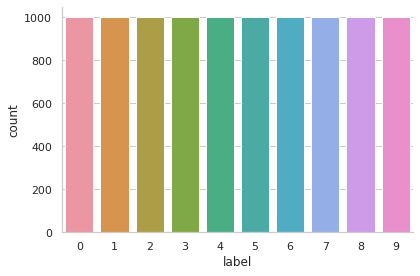

In [ ]:
import seaborn as sns
# import matplotlib
# from matplotlib import pyplot as plt

sns.set(context="notebook", palette="Accent", style = 'whitegrid' , color_codes=True)
sns.catplot(x='label', y='count', data=df, height=4, kind='bar', aspect=1.5)

In [ ]:
import numpy as np
import pandas as pd
import itertools

# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, concatenate, AveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import keras
from keras.utils.vis_utils import plot_model
import numpy as np
# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt



In [ ]:
#load dataset
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

#reshape dataset to have a single channel
trainX = trainX.reshape(trainX.shape[0], 28, 28, 1)
testX = testX.reshape(testX.shape[0], 28, 28, 1)

#one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

In [ ]:
def poly_decay(epoch):
    # initialize the maximum number of epochs, base learning rate,
    # and power of the polynomial
    maxEpochs = 60
    baseLR = 5e-3
    power = 1.0

    # compute the new learning rate based on polynomial decay
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power

    # return the new learning rate
    return alpha

In [ ]:
#Learning rate decay and data augmentation

reduce_lr = LearningRateScheduler(poly_decay)

datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)
datagen.fit(trainX)

In [ ]:
def conv_module(x, K, kX, kY, stride, chanDim, padding = "same"):
    # define a CONV => BN => RELU pattern
    x = Conv2D(K, (kX, kY), strides = stride, padding = padding)(x)
    x = BatchNormalization(axis = chanDim)(x)
    x = Activation("relu")(x)

    # return the block
    return x
def inception_module(x, numK1x1, numK3x3, chanDim):
    # define two CONV modules, then concatenate across the channel dimension
    conv_1x1 = conv_module(x, numK1x1, 1, 1, (1, 1), chanDim)
    conv_3x3 = conv_module(x, numK3x3, 3, 3, (1, 1), chanDim)
    x = concatenate([conv_1x1, conv_3x3], axis = chanDim)

    # return the block
    return x
def downsample_module(x, K, chanDim):
    # define the CONV module and POOL, then concatenate across the channel dimensions
    conv_3x3 = conv_module(x, K, 3, 3, (2, 2), chanDim, padding = "valid")
    pool = MaxPooling2D((3, 3), strides = (2, 2))(x)
    x = concatenate([conv_3x3, pool], axis = chanDim)

    # return the block
    return x

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 96)   960         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 96)  384         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 28, 28, 96)   0           ['batch_normalization[0][0]']

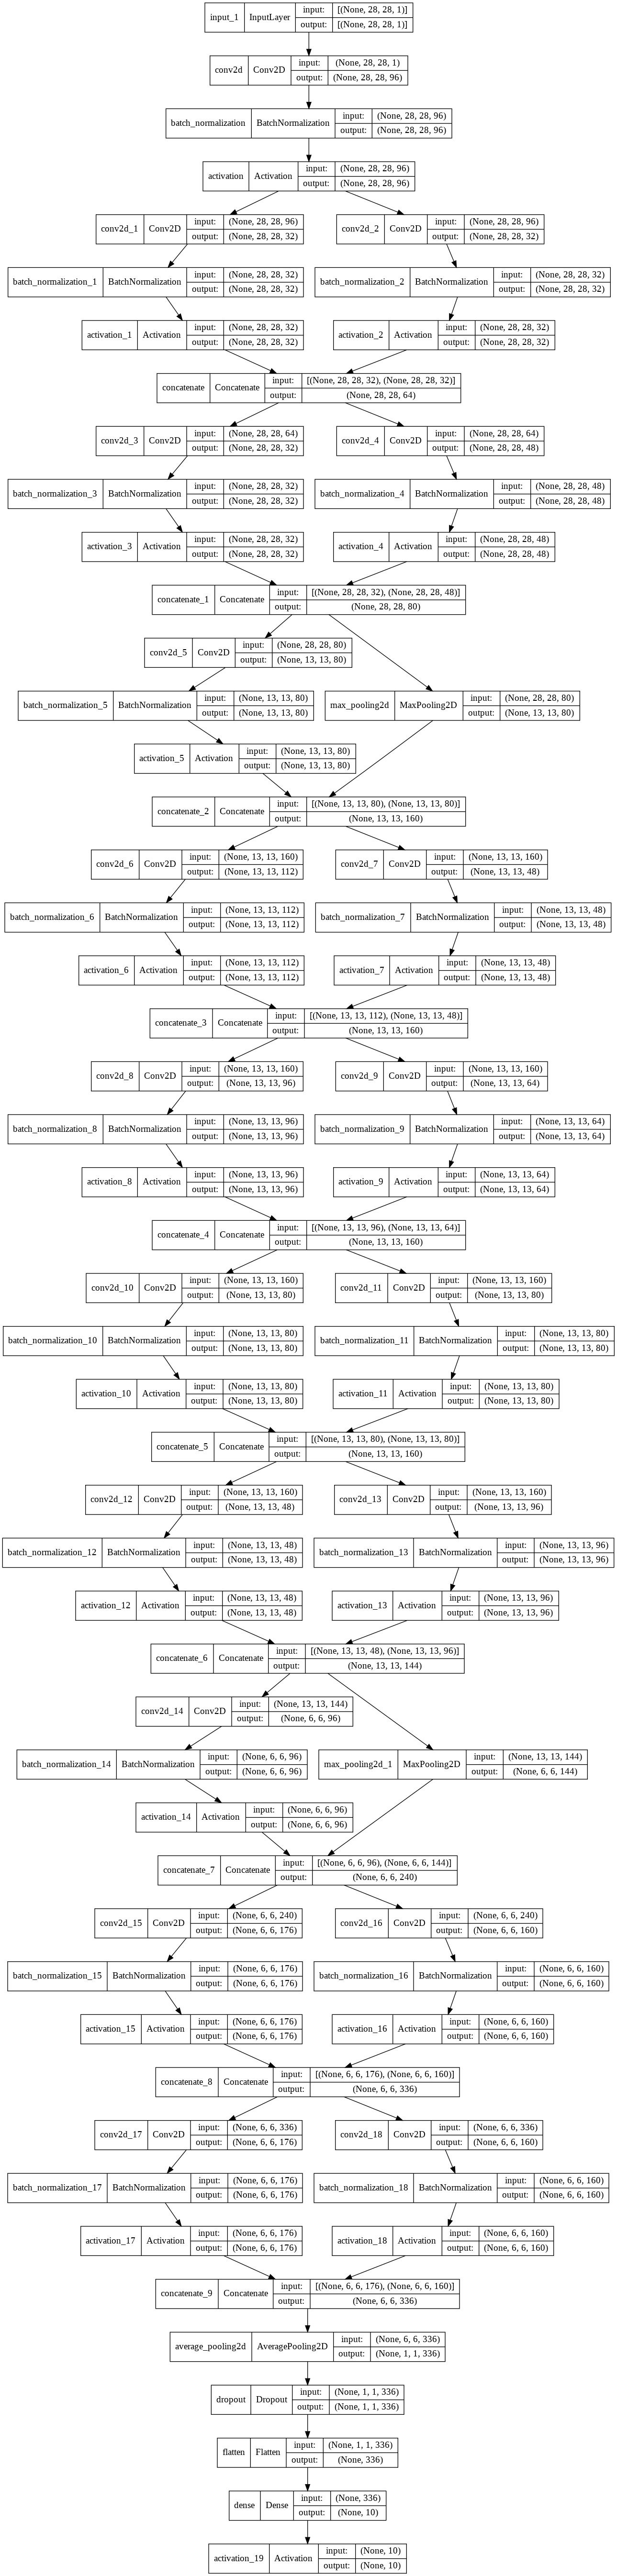

In [ ]:
inputs = Input(shape = (28, 28, 1))
x = conv_module(inputs, 96, 3, 3, (1, 1), -1)

x = inception_module(x, 32, 32, -1)
x = inception_module(x, 32, 48, -1)
x = downsample_module(x, 80, -1)

# four Inception module followed by a downsample module
x = inception_module(x, 112, 48, -1)
x = inception_module(x, 96, 64, -1)
x = inception_module(x, 80, 80, -1)
x = inception_module(x, 48, 96, -1)
x = downsample_module(x, 96, -1)

# two Inception module followed by global POOL and dropout
x = inception_module(x, 176, 160, -1)
x = inception_module(x, 176, 160, -1)
x = AveragePooling2D((5, 5))(x)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x = Dense(10)(x)
x = Activation("softmax")(x)

# create the model
model = Model(inputs, x)
model.summary()
# plot_model(model, show_shapes=True, to_file='googlenet.png')
plot_model(model, to_file='/content/drive/MyDrive/model.png', show_shapes=True, show_layer_names=True)

In [ ]:
opt = SGD(lr = 5e-3, momentum = 0.9)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
# history = model.fit_generator(datagen.flow(trainX, trainY, batch_size = 64), epochs = 60, 
#                               validation_data = (testX, testY), verbose=2, 
#                               steps_per_epoch=trainX.shape[0] // 64,
#                               callbacks = [reduce_lr])
history = model.fit(trainX, trainY, batch_size = 64, epochs = 30, 
                              validation_data = (testX, testY), verbose=2, callbacks = [reduce_lr])
model.save('/content/drive/MyDrive/googlenet_with_fashion_mnist2.h5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
938/938 - 89s - loss: 0.5261 - accuracy: 0.8080 - val_loss: 0.4255 - val_accuracy: 0.8486 - lr: 0.0050 - 89s/epoch - 95ms/step
Epoch 2/30
938/938 - 76s - loss: 0.3154 - accuracy: 0.8870 - val_loss: 0.3278 - val_accuracy: 0.8714 - lr: 0.0049 - 76s/epoch - 81ms/step
Epoch 3/30
938/938 - 75s - loss: 0.2564 - accuracy: 0.9086 - val_loss: 0.2671 - val_accuracy: 0.9042 - lr: 0.0048 - 75s/epoch - 80ms/step
Epoch 4/30
938/938 - 75s - loss: 0.2162 - accuracy: 0.9217 - val_loss: 0.2951 - val_accuracy: 0.8997 - lr: 0.0047 - 75s/epoch - 80ms/step
Epoch 5/30
938/938 - 77s - loss: 0.1864 - accuracy: 0.9337 - val_loss: 0.2598 - val_accuracy: 0.9034 - lr: 0.0047 - 77s/epoch - 82ms/step
Epoch 6/30
938/938 - 75s - loss: 0.1584 - accuracy: 0.9432 - val_loss: 0.2382 - val_accuracy: 0.9183 - lr: 0.0046 - 75s/epoch - 80ms/step
Epoch 7/30
938/938 - 75s - loss: 0.1367 - accuracy: 0.9506 - val_loss: 0.2464 - val_accuracy: 0.9201 - lr: 0.0045 - 75s/epoch - 80ms/step
Epoch 8/30
938/938 - 75s - loss: 0

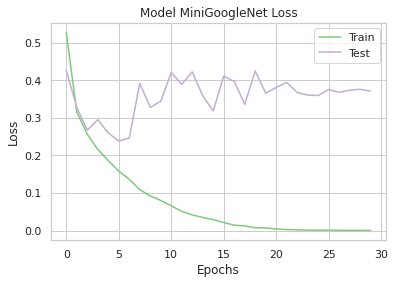

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model MiniGoogleNet Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()
plt.savefig('/content/drive/MyDrive/Model_MiniGoogleNet_Loss2.jpg')

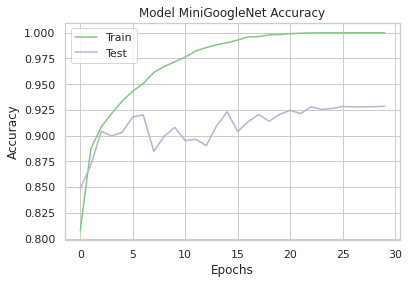

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model MiniGoogleNet Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()
plt.savefig('/content/drive/MyDrive/Model_MiniGoogleNet_Accuracy2.jpg')

In [ ]:
score = model.evaluate(trainX, trainY)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

1875/1875 [==============================] - 34s 18ms/step - loss: 6.7795e-05 - accuracy: 1.0000
Loss: 0.0001
Accuracy: 1.0000


In [ ]:
model1 = load_model('/content/drive/MyDrive/googlenet_with_fashion_mnist.h5')
score = model1.evaluate(trainX, trainY)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

1875/1875 [==============================] - 32s 17ms/step - loss: 0.1022 - accuracy: 0.9617
Loss: 0.1022
Accuracy: 0.9617


In [ ]:
score = model.evaluate(testX, testY)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

313/313 [==============================] - 6s 20ms/step - loss: 0.3712 - accuracy: 0.9286
Loss: 0.3712
Accuracy: 0.9286


In [ ]:
score = model1.evaluate(testX, testY)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

313/313 [==============================] - 7s 20ms/step - loss: 0.2279 - accuracy: 0.9266
Loss: 0.2279
Accuracy: 0.9266


In [ ]:
import matplotlib as mpl
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno




def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='MiniGoogleNet Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

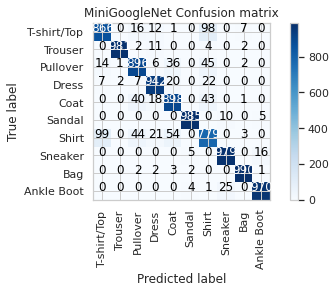

In [ ]:

# Predict the values from the validation dataset
Y_pred = model.predict(testX)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(testY,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])
plt.savefig('/content/drive/MyDrive/MiniGoogleNet_Confusion_Matrix2.png')

In [ ]:
labelNames = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
predictions = model.predict(testX, batch_size = 64)
print(classification_report(testY.argmax(axis = 1),
    predictions.argmax(axis = 1), target_names = labelNames))


              precision    recall  f1-score   support

 T-shirt/top       0.88      0.87      0.87      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.89      0.90      0.89      1000
       Dress       0.93      0.94      0.94      1000
        Coat       0.89      0.90      0.89      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.79      0.78      0.78      1000
     Sneaker       0.97      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

